In [1]:
#!/usr/bin/env python3
# initialization
%reset -f 
import importlib
import matplotlib.pyplot as plt

# importing Qiskit
from qiskit import transpile

# import basic plot tools
import matplotlib.pyplot as plt
import json
from qiskit.result import Result
import utilitiesRepetitionCode as utl
import qiskit
import utilities as commonUtl
importlib.reload(commonUtl)
importlib.reload(utl)

import matplotlib as mpl
mpl.rcParams['text.usetex'] = True # For latex plots
mpl.rcParams.update({'font.size': 12})
mpl.rcParams.update({'font.family': "Times"})

basis1 = ["h", "s", "sdg", "cx", "t", "cxx"]
basis2 = ["cx", "id", "rz", "sx", "x"]

lay_geneva1=[0,1]
lay_geneva2=[0,4,1,7]
lay_geneva3=[0,4,10,1,7,12]
lay_geneva4=[0,4,10,15,1,7,12,18]
lay_geneva5=[0,4,10,15,21,1,7,12,18,23]
lay_geneva6=[0,4,10,15,21,3,1,7,12,18,23,5]
lay_geneva7=[0,4,10,15,21,3,8,1,7,12,18,23,5,11]
lay_geneva8=[0,4,10,15,21,3,8,14,1,7,12,18,23,5,11,16]
lay_geneva9=[0,4,10,15,21,3,8,14,19,1,7,12,18,23,5,11,16,22]
lay_geneva10=[0,4,10,15,21,3,8,14,19,25,1,7,12,18,23,5,11,16,22,26]
layouts=[lay_geneva1,lay_geneva2,lay_geneva3,lay_geneva4,lay_geneva5,
            lay_geneva6,lay_geneva7,lay_geneva8,lay_geneva9,lay_geneva10]

# backend="ibm_washington"
# backend_name="ibm_geneva"
job_id="cioqts4t4v68ftbjlbvg" #ibm_hanoi 100k shots
EXISTING_JOB=True

In [2]:
backend_name="ibm_hanoi"
# backend_name="ibm_cairo"
# backend_name="ibm_auckland"
# backend=provider.get_backend(backend_name)
encoding_reps=list(range(1, 11)) #1 rep means no encoding
circs_to_exec=[]
SHOTS=100000
# err_val=1e-02
gate_rep=11 #Cnot repetition amount. The circuit is just repeated cnots
# Unencoded circ in the IBM basis (cx is this basis as well). The initial transpile isn't to a backend
# because we need to encode it and it would not be correct to include all the qubits in the backend in
# the input circuit to be encoded.
circ = transpile(utl.testcirc_cx_11init(gate_rep), basis_gates=basis2, optimization_level=0)
correct_answer = commonUtl.to_percentages(commonUtl.keys_to_binary(
    commonUtl.execute_circ_with_depol(circ, 0, SHOTS)))

if not EXISTING_JOB:
    # attach all the different circs that need to be executed.
    circs_to_exec.append(transpile(circ, backend=backend, optimization_level=0, initial_layout=layouts[0]))
    for idx, encoding_rep in enumerate(encoding_reps[1:]): # We skip the first value because that's not encoded.
        # We attached the 1 rep circ above.
        # Encoded circ
        coded_circ = utl.Encodings.to_encoded_circ_IBMBasis(circ, encoding_rep)
        #append the transpiled circ. layouts is started from index 1 since we already attached the unencoded case above.
        circs_to_exec.append(transpile(coded_circ, backend=backend, optimization_level=0, initial_layout=layouts[1:][idx]))

    # for circ in circs_to_exec:
    # print(circs_to_exec[9])
    # raw counts
    counts= commonUtl.run_hardware(circs_to_exec, backend, SHOTS)
else:
    with open(f"job-{job_id}/{job_id}-result.txt") as f:
        data=json.load(f)
    counts = Result.from_dict(data).get_counts()

In [3]:
coded_sso = [] #SSO results
post_select_rates=[]
post_select_counts=[]
post_select_dists=[]
#Append the unencoded post selection rate. This should be 1 since there is no post selection.
post_select_rates.append(sum(counts[0].values())/SHOTS)
not_encoded_dist=(commonUtl.keys_to_binary(commonUtl.to_percentages(counts[0])))
coded_sso.append(commonUtl.get_sso(not_encoded_dist, correct_answer))
post_select_counts.append(counts[0])
post_select_dists.append(not_encoded_dist)
#We pass the different layouts starting from index 1.
for idx, count in enumerate(counts[1:]):
    code_rep=encoding_reps[1:][idx]
    post_select_count=utl.post_select(count, code_rep, logical_bases={"0"*code_rep: "0", "1"*code_rep: "1"})
    # Raw post selected results converted to percentages
    post_select_dist = commonUtl.keys_to_binary(commonUtl.to_percentages(post_select_count))
    # Append values 
    post_select_rates.append(sum(post_select_count.values())/SHOTS)
    coded_sso.append(commonUtl.get_sso(post_select_dist, correct_answer))
    post_select_counts.append(post_select_count)
    post_select_dists.append(post_select_dist)
    print(circ)
    # print(coded_circ)
    # print(f"post selected results distribution: {post_select_dists}")
    # print(f"post selected counts: {post_select_count}")
    # print(f"post selected rates: {post_select_rate}")

print(f"post selected counts: {post_select_counts}")
print(f"post selected dists: {post_select_dists}")
print(f"post selected rates: {post_select_rates}")


        ┌───┐                                                        ░ ┌─┐   
   q_0: ┤ X ├──■────■────■────■────■────■────■────■────■────■────■───░─┤M├───
        ├───┤┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐ ░ └╥┘┌─┐
   q_1: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├─░──╫─┤M├
        └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘ ░  ║ └╥┘
meas: 2/════════════════════════════════════════════════════════════════╩══╩═
                                                                        0  1 
        ┌───┐                                                        ░ ┌─┐   
   q_0: ┤ X ├──■────■────■────■────■────■────■────■────■────■────■───░─┤M├───
        ├───┤┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐ ░ └╥┘┌─┐
   q_1: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├─░──╫─┤M├
        └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘ ░  ║ └╥┘
meas: 2/════════════════════════════════════════════════════════

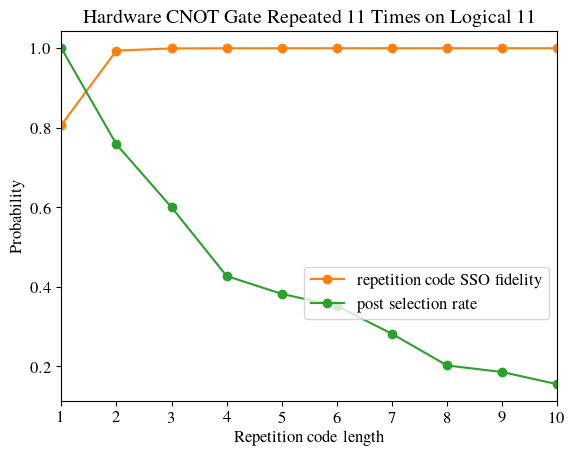

encoded sso: [0.8068999999999998, 0.9941444114737884, 0.9994834022130382, 0.9999064130460213, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
post selection rate: [1.0, 0.75825, 0.60008, 0.42741, 0.38241, 0.35195, 0.28204, 0.20246, 0.186, 0.15532]
correct: {'0b1': 1.0}


In [4]:
fig, ax = plt.subplots()
# plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.xlim([encoding_reps[0], encoding_reps[-1]])
plt.xticks(encoding_reps)
# ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%2.2e'))
plt.plot(encoding_reps, coded_sso, label=f"repetition code SSO fidelity", marker="o", color="C1")
plt.plot(encoding_reps, post_select_rates, label=f"post selection rate", marker="o", color="C2")
plt.ylabel('Probability')
plt.xlabel("Repetition code length")
plt.title(f"Hardware CNOT Gate Repeated {gate_rep} Times on Logical 11")
plt.legend(bbox_to_anchor=(1, 0.2), loc='lower right')
plt.show()
print(f"encoded sso: {coded_sso}")
print(f"post selection rate: {post_select_rates}")
print(f"correct: {correct_answer}")


std_dev:  0.5
lower condition:  0.0
upper condition:  1.0

std_dev:  0.7071067811865476
lower condition:  0.2928932188134524
upper condition:  1.7071067811865475

std_dev:  0.8660254037844386
lower condition:  0.6339745962155614
upper condition:  2.3660254037844384

std_dev:  1.0
lower condition:  1.0
upper condition:  3.0

std_dev:  1.118033988749895
lower condition:  1.381966011250105
upper condition:  3.618033988749895

std_dev:  1.224744871391589
lower condition:  1.775255128608411
upper condition:  4.224744871391589

std_dev:  1.3228756555322954
lower condition:  2.1771243444677046
upper condition:  4.822875655532295

std_dev:  1.4142135623730951
lower condition:  2.585786437626905
upper condition:  5.414213562373095

std_dev:  1.5
lower condition:  3.0
upper condition:  6.0

std_dev:  1.5811388300841898
lower condition:  3.41886116991581
upper condition:  6.58113883008419



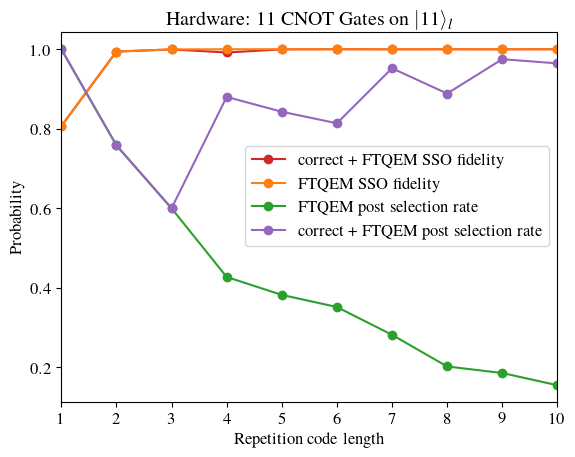

error correction + post selection sso: [0.8068999999999998, 0.9941444114737884, 0.9994834022130382, 0.9917741294097596, 0.9995965923922072, 0.9999754254469497, 0.99977944651578, 0.9998874634256134, 0.9997640783670119, 0.9999585247244488]
error correction post selection rate: [1.0, 0.75825, 0.60008, 0.88015, 0.84282, 0.81385, 0.95215, 0.8886, 0.9749, 0.96443]
encoded sso: [0.8068999999999998, 0.9941444114737884, 0.9994834022130382, 0.9999064130460213, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
post selection rate: [1.0, 0.75825, 0.60008, 0.42741, 0.38241, 0.35195, 0.28204, 0.20246, 0.186, 0.15532]
correct: {'0b1': 1.0}


In [5]:
importlib.reload(utl)
corrected_counts=[utl.correct(val, idx+1) for idx, val in enumerate(counts)]

error_corrected_sso=[]
corrected_post_select_counts=[]
corrected_post_select_dists=[]
corrected_post_select_rates=[]
for idx, vals in enumerate(corrected_counts):
    corrected_post_select_count=utl.post_select(vals, idx+1, logical_bases={"0"*(idx+1): "0", "1"*(idx+1): "1"})
    corrected_post_select_dist=commonUtl.keys_to_binary(commonUtl.to_percentages(corrected_post_select_count))
    error_corrected_sso.append(commonUtl.get_sso(corrected_post_select_dist, correct_answer))
    corrected_post_select_counts.append(corrected_post_select_count)
    corrected_post_select_dists.append(corrected_post_select_dist)
    corrected_post_select_rates.append(sum(corrected_post_select_count.values())/SHOTS)

fig, ax = plt.subplots()
plt.xlim([encoding_reps[0], encoding_reps[-1]])
plt.xticks(encoding_reps)
plt.plot(encoding_reps, error_corrected_sso, label=f"correct + FTQEM SSO fidelity", marker="o", color="C3")
plt.plot(encoding_reps, coded_sso, label=f"FTQEM SSO fidelity", marker="o", color="C1")
plt.plot(encoding_reps, post_select_rates, label=f"FTQEM post selection rate", marker="o", color="C2")
plt.plot(encoding_reps, corrected_post_select_rates, label=f"correct + FTQEM post selection rate", marker="o", color="C4")
plt.ylabel('Probability')
plt.xlabel("Repetition code length")
plt.title(f"Hardware: {gate_rep} CNOT Gates on " + r"$|11\rangle_l$")
plt.legend(bbox_to_anchor=(1.0, 0.4), loc='lower right')
plt.show()
print(f"error correction + post selection sso: {error_corrected_sso}")
print(f"error correction post selection rate: {corrected_post_select_rates}")
print(f"encoded sso: {coded_sso}")
print(f"post selection rate: {post_select_rates}")
print(f"correct: {correct_answer}")

In [6]:
qiskit.__version__

'0.23.3'